## Forecast validation for Euclid cosmological probes: Fisher Matrix
Student: Antonia Cisternas \
Teacher: Domenico Sapone

In [512]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats, interpolate
from scipy.misc import derivative
from scipy.integrate import cumulative_trapezoid, solve_ivp, odeint, quadrature, dblquad
import autograd.numpy as np
from autograd import grad 
import Power_spectrum
import camb
import scienceplots

In [513]:
# Calcular el tiempo de ejecución
import time
# Iniciar el temporizador
start_time = time.time()

In [514]:
plt.style.use(['science', 'bright'])
print(f"Versión de CAMB: {camb.__version__}")

Versión de CAMB: 1.5.8


In [515]:
redshifts = [1.65, 1.4, 1.2, 1.0]
kh = Power_spectrum.kh

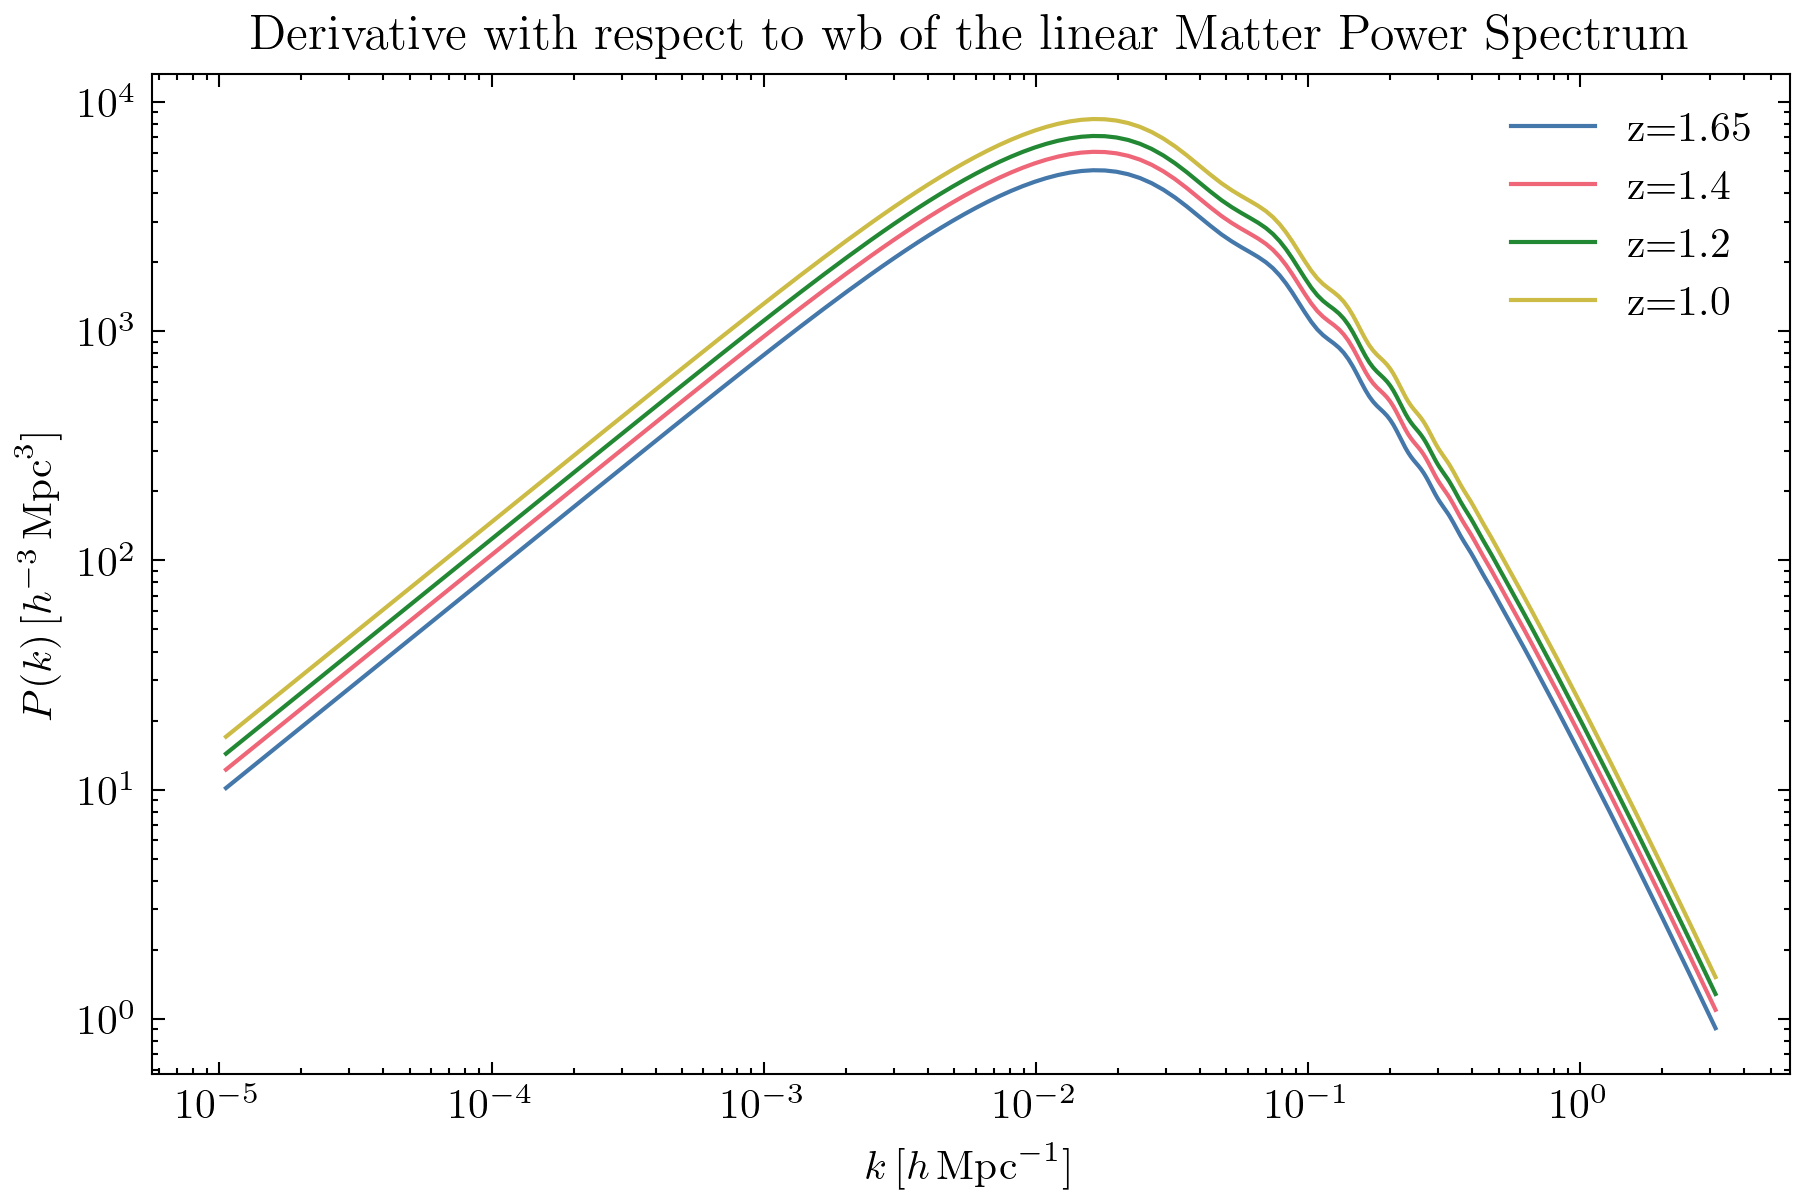

In [516]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, figsize=(6, 4), constrained_layout=True, dpi=300)
for z in redshifts:
    ax.loglog(kh, Power_spectrum.P_mn_b0(kh, z), label=f'z={z}')

ax.legend(loc='upper right')
ax.set_title('Derivative with respect to wb of the linear Matter Power Spectrum')
ax.set_xlabel(r'$k \, [h \, \mathrm{Mpc}^{-1}]$')
ax.set_ylabel(r'$P(k) \, [h^{-3} \, \mathrm{Mpc}^{3}]$')

plt.show()

### Fiducial parameters

The number density in each redshift bin is given by:
$$
n(z) = \frac{dN(z)}{d\Omega dz} \frac{A_{survey}}{V_s(z)} \Delta z
$$

In [517]:
# Based on table 3 of the page 14:
V_s = [7.94 * 10**(9), 9.15* 10**(9), 10.05* 10**(9), 16.22* 10**(9)] 

# galazy bias factor
b = [1.4614804, 1.6060949, 1.7464790, 1.8988660]

# Centered position of each bin
z_i = [1., 1.2, 1.4, 1.65]
z_min = [0.9, 1.1, 1.3, 1.5]
z_max = [1.1, 1.3, 1.5, 1.8]

In [518]:
#Fiducial parameters
wb = 0.022445
wm = 0.143648
h = 0.67
c = 300000

Omega_b0 = wb/ (h**2)
H0 = 100 * h
Omega_m0 = wm/ (h**2)
ns = 0.96 # Spectral index of the primordial density power spectrum
Omega_DE0 = 0.68

m_nu = 0.06
w0 = -1
wa = 0

gamma = 0.55

s8_reference= 0.815583

A_surv = 15000 # Survey area
s_z = 0.0001 # Spectroscopic redshift error
P_s = 0 # Shot noise

# Density per unit  área: dN/(dOmega dz)
dn3= [1815.0, 1701.5, 1410.0, 940.97]

# Based on table 3 of the page 14:
# n = [6.86 * 10**(-4), 5.58 * 10**(-4), 4.21* 10**(-4), 2.61 * 10**(-4)]
n = np.zeros_like(z_i)
for i in range(len(z_i)):
    n[i] = dn3[i] * A_surv * (z_max[i] - z_min[i])/ V_s[i]

print('n:', n)


n: [0.00068577 0.00055787 0.0004209  0.00026106]


### Imput files
Archives "Pk-fiducial-z_0_.dat" and "Pknw-fiducial-z_0_.dat" \
Columns: $k$ , $Pk/ s_8^2$ ,  $s_8$

In [519]:
    # For Pk
file_paths = [f"Pk-fiducial/Pk-fiducial-z_0{i}.dat" for i in range(len(z_i))]
Pk_data = [np.loadtxt(file) for file in file_paths]

    # For Pk_nw (no wiggled power spectrum)
file_paths_nw = [f"Pk-nw-fiducial/Pk-nw-fiducial-z_0{i}.dat" for i in range(len(z_i))]
Pk_data_nw = [np.loadtxt(file) for file in file_paths_nw]

    # For the derivatives of Pk and Pk_nw
# Derivatives with negative step (mn) and positive step (pl)
param = ['h', 'ns', 'wb', 'wm']
data_types = ['Pk_data_mn', 'Pk_data_pl', 'Pk_data_nw_mn', 'Pk_data_nw_pl']
data_arrays = {name: np.empty((len(z_i), len(param)), dtype=object) for name in data_types}

for param_index, j in enumerate(param):
  for i in range(len(z_i)):
        data_arrays['Pk_data_mn'][i][param_index] = np.loadtxt(f"Pk-derivative/Pk_{j}_mn_eps_1p0E-2/Pk-{j}_mn_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_pl'][i][param_index] = np.loadtxt(f"Pk-derivative/Pk_{j}_pl_eps_1p0E-2/Pk-{j}_pl_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_nw_mn'][i][param_index] = np.loadtxt(f"Pk-nw-derivative/Pk_{j}_mn_eps_1p0E-2/Pk-nw-{j}_mn_eps_1p0E-2-z_{i:02d}.dat")
        data_arrays['Pk_data_nw_pl'][i][param_index] = np.loadtxt(f"Pk-nw-derivative/Pk_{j}_pl_eps_1p0E-2/Pk-nw-{j}_pl_eps_1p0E-2-z_{i:02d}.dat")

# Example: Accessing elements
# To access Pk_data_mn for the bin 0 and the parameter ns:
# example_data = data_arrays['Pk_data_mn'][0][1]

### Interpolation

In [520]:
# Cubic spline interpolation:
# Function to initialize and interpolate data
def initialize_interpolation(data):
    k = np.empty(len(z_i), dtype=object)
    P_ = np.empty(len(z_i), dtype=object)
    k_new = np.empty(len(z_i), dtype=object)

    for i in range(len(z_i)):
        k[i] = np.log(data[i][:, 0])
        # Teacher made this with Pk/sigma8(z)**2 but I did all with Pk
        #P_[i] = interpolate.interp1d(k[i], np.log(data[i][:, 1] * (data[i][:, 2]**2)), kind='cubic')
        P_[i] = interpolate.interp1d(k[i], np.log(data[i][:, 1]), kind='cubic')
        k_new[i] = np.log(np.arange(data[i][:, 0][0], data[i][:, 0][-1], 0.0001))
    
    return k, P_, k_new

# Initialize and interpolate data for Pk_data and Pk_data_nw
k, P_dd_, k_new = initialize_interpolation(Pk_data)
k_nw, P_nw_, k_nw_new = initialize_interpolation(Pk_data_nw)

# Functions to get the interpolated power spectrum for a given k and redshift
def P_dd(k, zi):
    i = z_i.index(zi)
    return P_dd_[i](k)

def P_nw(k, zi):
    i = z_i.index(zi)
    return P_nw_[i](k)

For the derivatives with positive and negative steps:

In [521]:
# Function to initialize and interpolate data
def initialize_interpolation(data_key):
    k = np.empty((len(z_i), len(param)), dtype=object)
    P_ = np.empty((len(z_i), len(param)), dtype=object)
    k_new = np.empty((len(z_i), len(param)), dtype=object)

    for j in range(len(param)):
        for i in range(len(z_i)):
            k[i][j] = np.log(data_arrays[data_key][i][j][:, 0])
            #P_[i][j] = interpolate.interp1d(k[i][j], np.log(data_arrays[data_key][i][j][:, 1] * (data_arrays[data_key][i][j][:, 2]**2)), kind='cubic')
            P_[i][j] = interpolate.interp1d(k[i][j], np.log(data_arrays[data_key][i][j][:, 1]), kind='cubic')
            k_new[i][j] = np.log(np.arange(data_arrays[data_key][i][j][:, 0][0], data_arrays[data_key][i][j][:, 0][-1], 0.0001))
    
    return k, P_, k_new

# Initialize and interpolate data for each dataset
k_mn, P_mn_, k_mn_new = initialize_interpolation('Pk_data_mn')
k_pl, P_pl_, k_pl_new = initialize_interpolation('Pk_data_pl')
k_nw_mn, P_nw_mn_, k_nw_mn_new = initialize_interpolation('Pk_data_nw_mn')
k_nw_pl, P_nw_pl_, k_nw_pl_new = initialize_interpolation('Pk_data_nw_pl')

# Functions to get the interpolated power spectrum for a given k and redshift
def P_mn(k, zi, j):
    i = z_i.index(zi)
    return P_mn_[i][j](k)

def P_pl(k, zi, j):
    i = z_i.index(zi)
    return P_pl_[i][j](k)

def P_nw_mn(k, zi, j):
    i = z_i.index(zi)
    return P_nw_mn_[i][j](k)

def P_nw_pl(k, zi, j):
    i = z_i.index(zi)
    return P_nw_pl_[i][j](k)

### Graphs of the interpolation

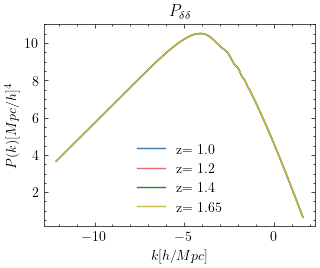

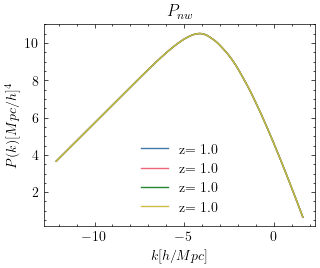

In [522]:
plt.title(r"$P_{\delta \delta}$")
for i in range(0,len(z_i)):
    plt.plot(k_new[i], P_dd_[i](k_new[i]), '-', label= f"z= {z_i[i]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()

plt.title(r"$P_{nw}$")
for i in range(0,len(z_i)):    
    plt.plot(k_nw_new[i], P_nw_[i](k_nw_new[i]), '-', label= f"z= {z_i[0]}")
plt.xlabel(r"$k[h/Mpc]$")
plt.ylabel(r"$P(k)[Mpc/h]^4$")
plt.legend()
plt.show()


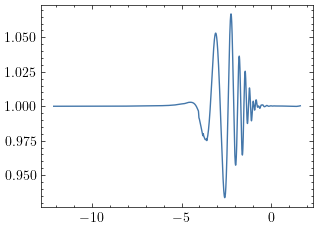

In [523]:
def frac(k, ks):
    return np.exp(P_nw_[0](ks))/np.exp(P_dd_[0](k))

plt.plot(k_nw_new[0], frac(k_new[0], k_nw_new[0]))
         

### Sigma 8

In [524]:
def sigma80(z):
    bin = z_i.index(z)
    return Pk_data[bin][0, 2]

### Defining functions

Parámetros a encontrar:
$D_A(z_i)$, $H(z_i)$, $f\sigma_8(z_i)$, $b\sigma_8$ , $P_s(z_i)$, $\omega_{b,0}$, $h$, $\omega_{m,0}$, $n_s$, $\sigma_v (z_{mean})$ y $\sigma_p (z_{mean})$


In [525]:
class Func_of_PS:
    # Put the fiducial parameters ito the args
    #def __init__(self):
        #self.z_mean = (z_max[3]-z_min[0])/2 + z_min[0]

    # For de derivatives with respect to h:
    def Omega_m0(self, wm):
        return wm/ (h**2)
    
    def Omega_DE0(self, wm):
        return 1 - self.Omega_m0(wm)
    
    def Omega_m(self, z):
        return self.Omega_m0(wm)* (1+z)**3/(self.E(z)**2)
    
    def r(self, z):
        z_values = np.linspace(0, z, 1000)
        H0 = 100 * h
        a = 1 / self.E(z_values)
        integral = cumulative_trapezoid(a, z_values, initial=0)
        return c/ H0 * integral[-1]

    def D_A(self, z):
        H_0 = 100 * h
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        if Omega_k0 < 0:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Omega_k0))* np.sin(np.sqrt(-Omega_k0) * (H_0/c) * self.r(z))
        elif Omega_k0 == 0:
            return (1+z)**(-1) * self.r(z) 
        else:
            return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Omega_k0))* np.sinh(np.sqrt(Omega_k0) * (H_0/c) * self.r(z))
        
    def E(self, z):
        Omega_k0 = 1- Omega_m0 - Omega_DE0
        return np.sqrt(Omega_m0* ((1+z)**3) + Omega_DE0*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

    def H(self, a):
        H0 = 100 * h
        z= 1/a -1
        return H0* self.E(z)

    def f_gamma(self, z, gamma):
        return self.Omega_m(z)**gamma
    
    def H_derivative(self, a, eps= 1e-6):
        return derivative(self.H, a, dx=eps)

    def fmodel(self, f, a):
        dfda= -f**2/a-(2/a + (self.H_derivative(a))/self.H(a))*f + 3*self.Omega_m(1/a-1)/(2*a)
        return dfda

    # obtaining the value of f
    def fint(self, z):
        f0=1
        # Scale factor values
        aint = np.linspace(0.01,1.0,101)
        fmodelint = odeint(self.fmodel, f0, aint)
        fmodelintf = np.asarray(fmodelint).squeeze()
        interp_type = 'cubic'
        return interpolate.interp1d(aint,fmodelintf,kind=interp_type)(1/(1+z))

    def growth(self,z):
        return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])

    # fs8(z) = sigma_8(z) * f(z)
    # = sigma8 * f(z)*D(z)/(1+z)
    def fs8anal(self, z):
        return sigma80(z)*self.fint(z)*self.growth(z)/(1+z)

    # bs8 lo defino con la lista inicial
    def bs8(self, z):
        bin = z_i.index(z)
        return b[bin] * self.s8anal(z)
    
    # s8(z) = sigma8 * D(z)
    def s8anal(self, z):
        return sigma80(z)*self.growth(z)
    
    def sv(self, zi):
        j = z_i.index(zi)
        #I = np.trapz(np.exp(P_dd(k_new[j], z_i[j])), np.exp(k_new[j]))
        I = np.trapz(np.exp(P_dd(k_new[j], zi)), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I)
    
    def sp(self, zi):
        j = z_i.index(zi)
        I = np.trapz(np.exp(P_dd(k_new[j], zi)), np.exp(k_new[j]))
        return np.sqrt((1/(6* (np.pi**2)))* I) / self.s8anal(zi)
    
    # z_mean = z_i[1] aproximadamente para el segundo bin

    def sigma_v(self, z):
        z_mean_bin = z_i[1]
        return self.sv(z_mean_bin) * self.growth(z)/self.growth(z_mean_bin)

    def sigma_p(self, z):
        z_mean_bin = z_i[1]
        return self.sp(z_mean_bin) * self.growth(z)/self.growth(z_mean_bin)
    
    # Comoving distance error sigma_r = (c/H(z))*(1+z)* sigma_{0,z}
    def F_z(self, k, u, z, H): 
        return np.exp(-((k* u* c *(1+z)* s_z)/ H)**2)

    def qpar(self, z, H):
        return self.H(z)/H

    def qper(self, z, D_A):
        return D_A/ self.D_A(z)

    # To convert the known reference k_ref and mu_ref to the unknown, true k and mu
    def k(self, z, k_ref, u_ref, H, D_A):
        qper = self.qper(z, D_A)
        qpar = self.qpar(z, H)
        return (k_ref /qper)* (1 + u_ref**2 *((qper**2/qpar**2) -1))**(0.5)

    def u(self, z, u_ref, H, D_A):
        qper1 = self.qper(z, D_A)
        qpar1 = self.qpar(z, H)
        return u_ref * (qper1/qpar1) * (1 + u_ref**2 *((qper1**2/qpar1**2) -1))**(-0.5)

    # Non-linear damping factor of the BAO signal.
    def g_u(self, z, u, sv, fs8):
        return sv**2 *(1- u**2 + (u**2)*(1 + fs8/self.s8anal(z))**2)


#### Functions tests

In [526]:
Test = Func_of_PS()
print(Test.r(0))

qper= Test.qper(z_i[0], Test.D_A(z_i[0]))
print(qper)

k = Test.k(z_i[0], 0.1 , 0.34, Test.H(z_i[0]), Test.D_A(z_i[0]))
print('k:', k)

u = Test.u(z_i[0], 0.34, Test.H(z_i[0]), Test.D_A(z_i[0]))
print('u:', u)

f = [float(Test.fint(z_i[0])), float(Test.fint(z_i[1])), float(Test.fint(z_i[2])), float(Test.fint(z_i[3]))]
print('* obtained', 'f:', f)
print('f imput files:', [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483])
D = [float(Test.growth(z_i[0]))/(1+ z_i[0]), float(Test.growth(z_i[1]))/(1+ z_i[1]), float(Test.growth(z_i[2]))/(1+ z_i[2]), float(Test.growth(z_i[3]))/(1+ z_i[3])]
print('* obtained', 'D:', D)
print('D imput files:', [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316])

fs8 = Test.fs8anal(z_i[0])
print('fs8:', fs8)
s8anal = Test.s8anal(z_i[0])
print('s8:', s8anal)

print('------------------')

H = np.zeros_like(z_i)
D_A = np.zeros_like(z_i)
for i in range(len(z_i)):
    H[i] = Test.H(1/(1+z_i[i]))
    D_A[i] = Test.D_A(z_i[i])
print('H:', H)
print('D_A:', D_A)
print('------------------')
# For each bin
sigma_p = np.zeros_like(z_i)
sigma_v = np.zeros_like(z_i)
g_u = np.zeros_like(z_i)
for i in range(len(z_i)):
    sigma_p[i] = Test.sigma_p(z_i[i])
    sigma_v[i] = Test.sigma_v(z_i[i])
    g_u[i] = Test.g_u(z_i[i], 0.5 , Test.sigma_v(z_i[i]), Test.fs8anal(z_i[i]))
     
print('sigma_p:', sigma_p)
print('sigma_v:', sigma_v)
print('g_u (mu= 0.5): ', g_u)

0.0
1.0
k: 0.1
u: 0.34
* obtained f: [0.8790616402058237, 0.9052940319545524, 0.9248305629134211, 0.9426467977568916]
f imput files: [0.8790616234808487, 0.9052940279841754, 0.9248305916607235, 0.942646864519483]


C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:46: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(self.H, a, dx=eps)
C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:63: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])


* obtained D: [0.6051299101637972, 0.5557769208487298, 0.5132266725400016, 0.46785419760471764]
D imput files: [0.6051299241324081, 0.5557769195555776, 0.5132266632166314, 0.46785418122063316]
fs8: 0.2628746261794631
s8: 0.5980800757451175
------------------
H: [120.6        135.45537656 151.36188265 172.58294852]
D_A: [1707.04750733 1765.27662577 1792.77802623 1798.75951279]
------------------
sigma_p: [12.82384011 12.95575326 13.05148534 13.13699043]
sigma_v: [7.11830074 7.19152354 7.24466283 7.29212529]
g_u (mu= 0.5):  [64.25297452 64.54827437 64.546011   64.31481091]


#### Class Power Spectrum

In [527]:
class Obs_PS:
  def __init__(self, params):
        self.setting = params['setting']
        self.Func_of_PS_obj = Func_of_PS()

  def P_dw(self, k, u, z, sv, fs8, paso = None, var = None):
    if paso == None:
      return np.exp(P_dd(k, z))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw(k, z))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))
    
    elif paso == 'pl':
      return np.exp(P_pl(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw_pl(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))
      
    else:
      return np.exp(P_mn(k, z, var))* np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2) + np.exp(P_nw_mn(k, z, var))* (1- np.exp(-self.Func_of_PS_obj.g_u(z, u, sv, fs8)*k**2))

  def P_obs(self, k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A):
    k_eval = self.Func_of_PS_obj.k(z, k_ref, u_ref, H, D_A)
    u_eval = self.Func_of_PS_obj.u(z, u_ref, H, D_A)
    s8 = self.Func_of_PS_obj.s8anal(z)

    if self.setting == 'non-linear':
      return (1/(self.Func_of_PS_obj.qpar(z, H)**2 * self.Func_of_PS_obj.qper(z, D_A)))*((bs8 + (fs8* u_eval**2))**2/(1+(fs8*k_eval*u_eval*sp)**2)) * (self.P_dw(k_eval, u_eval, z, sv, fs8))* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, H) + P_s
      #return (1/(self.Func_of_PS_obj.qpar(z, H)**2 * self.Func_of_PS_obj.qper(z, D_A)))*((bs8 + (fs8* u_eval**2))**2/(1+(fs8*k_eval*u_eval*sp)**2)) * (self.P_dw(k_eval, u_eval, z, sv, fs8)/s8**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, H) + P_s
    else:
      return (1/(self.Func_of_PS_obj.qpar(z, H)**2 * self.Func_of_PS_obj.qper(z, D_A))) * ((bs8 + (fs8* u_eval**2))**2)**2 * (np.exp(P_dd(k_eval, z))/s8**2)* self.Func_of_PS_obj.F_z(k_eval, u_eval, z, H) + P_s


  def V_eff(self, k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A):
    bin = z_i.index(zi)
    return V_s[bin] * (((n[bin])* self.P_obs(k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A))/(n[bin]* self.P_obs(k_ref, u_ref, zi, bs8, fs8, sv, sp, H, D_A) + 1))**2



#### Test Class

In [528]:
# Ensure Obs_PS is the class name and not an instance
Obs_PS_class = Obs_PS  # Save the class reference

# Instantiate the class
Obs_PS_instance = Obs_PS_class({'setting': 'non-linear'})

# Call the method on the instance
result = Obs_PS_instance.P_obs(
    1, 1, z_i[0], 
    Test.bs8(z_i[0]), 
    Test.fs8anal(z_i[0]), 
    Test.sigma_v(z_i[0]), 
    Test.sigma_p(z_i[0]), 
    Test.H(z_i[0]), 
    Test.D_A(z_i[0])
)
print('P_obs', result)

print()
print('------------------')
print('z= 0')
k = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
print(f'k= {k}')
print('log(Pnw)=', P_nw(k, z_i[0]))
print('log(P_dd)=', P_dd(k, z_i[0]))
print('------------------')

print('z= 1.4')
k = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
print(f'k= {k}')
print('log(Pnw)=', P_nw(k, z_i[2]))
print('log(P_dd)=', P_dd(k, z_i[2]))


result3 = Obs_PS_instance.V_eff(1, 1, z_i[0], Test.bs8(z_i[0]), Test.fs8anal(z_i[0]), Test.sigma_v(z_i[0]), Test.sigma_p(z_i[0]), Test.H(z_i[0]), Test.D_A(z_i[0]))
print()
print('V_s', V_s[0])
print('V_eff', result3)


C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:63: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])
C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:46: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(self.H, a, dx=eps)


P_obs 0.437335245173326

------------------
z= 0
k= [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
log(Pnw)= [4.60626759 4.5831743  4.51381218 4.39798193 4.16460623 3.92929632]
log(P_dd)= [4.60603591 4.58298669 4.51370348 4.39779551 4.1644369  3.92909791]
------------------
z= 1.4
k= [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
log(Pnw)= [4.60634022 4.58324696 4.51388493 4.39805484 4.16467941 3.92936972]
log(P_dd)= [4.60610858 4.58305928 4.5137762  4.3978683  4.16450993 3.9291714 ]

V_s 7940000000.0
V_eff 713.7461250962664


### Derivatives

In [529]:
# epsilon varía entre los 0.0001 y 0.01
class Derivada_ln_P_obs:
  def __init__(self, params):
      self.Obs_PS_obj= Obs_PS(params)
      self.Func_of_PS_obj = Func_of_PS()

  def derivada_ln_P_obs(self, k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A, parameter, eps):
      s8 = self.Func_of_PS_obj.s8anal(z)
      if parameter == 'Ps':
        derivada = 1/ self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8, sv, sp, H, D_A)
        
      # if are shape parameters wb , h, wm , ns
      elif parameter == 'wb' or parameter== 'h' or parameter == 'wm' or parameter == 'ns':
        # str to function
        if parameter == 'wb':
          a = wb
        elif parameter == 'h':
          a = h
        elif parameter == 'wm':
          a = wm
        elif parameter == 'ns':
          a = ns
        
        for j in range(0,4):
          if parameter == param[j]:
            var = j
            #derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'pl', var = var)/s8**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'mn', var = var)/s8**2))/ (2 * a)
            derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'pl', var = var))- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, sv, fs8, paso = 'mn', var = var)))/ (2 * a)

      # if are non-linear parameters sv y sp
      # three-point stencil derivative of f with respect to x at x0
      elif parameter == 'sv':
        #derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1+eps) , fs8)/s8**2)- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1-eps) , fs8)/ s8**2)) / (2 * eps * self.Func_of_PS_obj.sigma_v(z))
        derivada = (np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1+eps) , fs8))- np.log(self.Obs_PS_obj.P_dw(k_ref, u_ref, z, self.Func_of_PS_obj.sigma_v(z)* (1-eps) , fs8))) / (2 * eps * self.Func_of_PS_obj.sigma_v(z))

      elif parameter == 'sp':
        term_pos = (self.Func_of_PS_obj.fint(z)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z)*(1 + eps))**2
        term_neg = (self.Func_of_PS_obj.fint(z)*k_ref* u_ref* self.Func_of_PS_obj.sigma_p(z)*(1 - eps))**2

        derivada = (np.log(1/ (1+ term_pos))- np.log(1 / (1+ term_neg))) / (2 * eps * self.Func_of_PS_obj.sigma_p(z))
        
      # if parameters are fs8 and bs8
      elif parameter == 'fs8':
        fs8_plus = self.Func_of_PS_obj.fs8anal(z)**(1 + eps)
        fs8_minus = self.Func_of_PS_obj.fs8anal(z)**(1 - eps)
        P_obs_plus = self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8_plus, sv, sp, H, D_A)
        P_obs_minus = self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8, fs8_minus, sv, sp, H, D_A)
        
        derivada = (np.log(P_obs_plus) - np.log(P_obs_minus)) / (2 * eps * np.log(self.Func_of_PS_obj.fs8anal(z)))

      elif parameter == 'bs8':
        derivada = (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, self.Func_of_PS_obj.bs8(z)**(1 + eps), fs8, sv, sp, H, D_A)) - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, self.Func_of_PS_obj.bs8(z)**(1 - eps), fs8, sv, sp, H, D_A))) / (2* eps * np.log(self.Func_of_PS_obj.bs8(z)))

      # if parameters are H and D_A, five point stencil
      elif parameter == 'H':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1+ eps), D_A)) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1- eps), D_A)))/(12* eps * np.log(self.Func_of_PS_obj.H(z))) \
                        - ((np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1+ 2*eps), D_A))) \
                           - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp,self.Func_of_PS_obj.H(z)**(1 - 2*eps), D_A)))/(12* eps * np.log(self.Func_of_PS_obj.H(z)))
      elif parameter == 'D_A':
        derivada = 8* (np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1+ eps))) \
                       - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1- eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z))) \
                        - ((np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1+ 2*eps)))) \
                           - np.log(self.Obs_PS_obj.P_obs(k_ref, u_ref, z, bs8 , fs8, sv, sp, H, self.Func_of_PS_obj.D_A(z)**(1-2* eps))))/(12* eps * np.log(self.Func_of_PS_obj.D_A(z)))
      return derivada


#### Test derivatives

In [530]:
Deriv = Derivada_ln_P_obs({'setting': 'non-linear'})
print('Derivatives of P_obs:')
print(range(0,4))

def print_derivative(var):
    deriv = Deriv.derivada_ln_P_obs(1, 1, z_i[0], Test.bs8(z_i[0]), Test.fs8anal(z_i[0]), Test.sigma_v(z_i[0]), Test.sigma_p(z_i[0]), Test.H(z_i[0]), Test.D_A(z_i[0]), var, 0.0001)
    print(f'{var}', deriv)

variables = ['Ps', 'wb', 'h', 'ns', 'wm', 'sv', 'sp', 'fs8', 'bs8', 'H', 'D_A']

for var in variables:
    print_derivative(var)

Derivatives of P_obs:
range(0, 4)


C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:63: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])
C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:46: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(self.H, a, dx=eps)


Ps 2.286575369894272
wb -0.09339450145966459
h -0.012986205329201639
ns 0.028458806986489858
wm 0.07437777503125295
sv 0.0
sp -0.1547418452094694
fs8 -1.375822924639578
bs8 1.5375820874096267
H -2.3159361793297855
D_A -1.0000000000001157


### Double integral

In [531]:
class Double_integral:
    def __init__(self, params):
        self.k_range = [0.001* h, 0.25 * h]
        self.u_range = [-1, 1]
        self.Derivada_obj = Derivada_ln_P_obs(params)
        self.Obs_PS_obj = Obs_PS(params)
        self.eps = 0.001

    def integrand(self, k, u, z, bs8, fs8, sv, sp, H, D_A, param1, param2):
        return (k)**2 * self.Derivada_obj.derivada_ln_P_obs(k, u, z, bs8, fs8, sv, sp, H, D_A, param1, self.eps) * self.Derivada_obj.derivada_ln_P_obs(k, u, z,bs8, fs8, sv, sp, H, D_A, param2, self.eps)* self.Obs_PS_obj.V_eff(k, u, z, bs8, fs8, sv, sp, H, D_A)

    def compute_double_integral(self, z, bs8, fs8, sv, sp, H, D_A, param1, param2):
            # Limites de integración
            k_lower = self.k_range[0]
            k_upper = self.k_range[1]
            u_lower = self.u_range[0]
            u_upper = self.u_range[1]

            # Number of steps for the trapezoidal rule
            num_steps_k = 100
            num_steps_u = 100

            # Create arrays for k and u values
            k_values = np.linspace(k_lower, k_upper, num_steps_k + 1)
            u_values = np.linspace(u_lower, u_upper, num_steps_u + 1)

            # Create a meshgrid for k and u
            K, U = np.meshgrid(k_values, u_values, indexing='ij')

            # Evaluate the integrand on the grid
            integrand_values = self.integrand(K, U, z, bs8, fs8, sv, sp, H, D_A, param1, param2)

            # Apply the trapezoidal rule
            integral_k = np.trapz(integrand_values, k_values, axis=0)
            integral = np.trapz(integral_k, u_values)

            # attribute: .T 
            # romb 

            return integral

In [532]:
# 'setting' should be: linear/ non-linear
# Test:   
w0 = -1
wa = 0

param1 = 'fs8'
param2 = 'h'

cosmic_params = {'setting' : 'non-linear'}
Double_integral_obj = Double_integral(cosmic_params)
#result = Double_integral_obj.compute_double_integral(z_i[0], bs8, fs8, sv, sp, H, D_A, param1, param2)


### Fisher matrix for a bin

In [533]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

class F_ij_first_bin:
    def __init__(self, params):
        self.Func_of_PS_obj = Func_of_PS()
        self.Double_integral_obj = Double_integral(params)

    def F_ij_bin(self, z):
        bs8 = self.Func_of_PS_obj.bs8(z)
        fs8 = self.Func_of_PS_obj.fs8anal(z)
        sv = self.Func_of_PS_obj.sigma_v(z)
        sp = self.Func_of_PS_obj.sigma_p(z)  
        H = self.Func_of_PS_obj.H(z)
        D_A = self.Func_of_PS_obj.D_A(z)

        param1_grid, param2_grid = np.meshgrid(parameters, parameters, indexing='ij')
        result_grid = np.zeros(param1_grid.shape)
        for i in range(param1_grid.shape[0]):
            for j in range(param1_grid.shape[1]):
                result_grid[i, j] = (1/(8 * np.pi**2)) * Double_integral_obj.compute_double_integral(
                    z, bs8, fs8, sv, sp, H, D_A, param1_grid[i, j], param2_grid[i, j])
                print(param1_grid[i, j], param2_grid[i, j], result_grid[i, j])
        
        return result_grid
    
F_ij_first_bin_obj = F_ij_first_bin(cosmic_params)
F_first_bin = F_ij_first_bin_obj.F_ij_bin(z_i[0])

C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:63: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])
C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:46: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(self.H, a, dx=eps)


wb wb 3.940364369026087
wb h 0.5280737727136025
wb wm -3.0437815237945505
wb ns -0.9677220162951585
wb sp 2.5945387721195567
wb sv -0.0009224858531742451
wb D_A 33.61124547673032
wb H -94.62024134175002
wb fs8 -4.004535007896033
wb bs8 -88.5904993616604
wb Ps -0.7223883270836362
h wb 0.5280737727136023
h h 0.07077144650634842
h wm -0.4079202720466009
h ns -0.12969488153331413
h sp 0.3479984560622767
h sv -0.00012369586303693565
h D_A 4.503261899219646
h H -12.678680025063493
h fs8 -0.5352910412772067
h bs8 -11.872575961539056
h Ps -0.09684681916874482
wm wb -3.0437815237945505
wm h -0.4079202720466009
wm wm 2.3512189679296043
wm ns 0.7475458454833783
wm sp -2.005456136728766
wm sv 0.0007129183816086314
wm D_A -25.958440564715243
wm H 73.08203865105897
wm fs8 3.087731418616413
wm bs8 68.43250381733428
wm Ps 0.5581594029044747
ns wb -0.9677220162951585
ns h -0.12969488153331413
ns wm 0.7475458454833783
ns ns 0.23768882535591151
ns sp -0.6390847036644983
ns sv 0.0002271284010701839
ns D_A

In [534]:
shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
redshift_param= [ 'D_A', 'H', 'fs8', 'bs8', 'Ps']
parameters = shape_param + redshift_param

# 6 x 6 matrix: shape parameters 
# 5 x 5 matrix: redshift dependant parameters

class F_ij_first_bin:
    def __init__(self, params):
        self.Func_of_PS_obj = Func_of_PS()
        self.Double_integral_obj = Double_integral(cosmic_params)

    def F_ij_bin(self, z):
        bs8 = self.Func_of_PS_obj.bs8(z)
        fs8 = self.Func_of_PS_obj.fs8anal(z)
        sv = self.Func_of_PS_obj.sigma_v(z)
        sp = self.Func_of_PS_obj.sigma_p(z)  
        H = self.Func_of_PS_obj.H(z)
        D_A = self.Func_of_PS_obj.D_A(z)

        param1_grid, param2_grid = np.meshgrid(parameters, parameters, indexing='ij')
        result_grid = (1/(8 * np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(z, bs8, fs8, sv, sp, H, D_A, param1_grid, param2_grid)
        return result_grid

# Covariance matrix for the first bin
F_first_bin = F_ij_first_bin(cosmic_params).F_ij_bin(z_i[0])
print('F_first_bin', F_first_bin)

C_bin = np.linalg.inv(F_first_bin)
print('C_bin:', C_bin)

C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:63: DeprecationWarning: `scipy.integrate.quadrature` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  return np.exp(-quadrature(lambda zx: (self.fint(zx) - 1)/(1+zx), 0, z)[0])
C:\Users\antoc\AppData\Local\Temp\ipykernel_9584\2877881432.py:46: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(self.H, a, dx=eps)


F_first_bin [[   3.94036437    0.52807377   -3.04378152   -0.96772202    2.59453877
    -0.00092249   33.61124548  -94.62024134   -4.00453501  -88.59049936
    -0.72238833]
 [   0.52807377    0.07077145   -0.40792027   -0.12969488    0.34799846
    -0.0001237     4.5032619   -12.67868003   -0.53529104  -11.87257596
    -0.09684682]
 [  -3.04378152   -0.40792027    2.35121897    0.74754585   -2.00545614
     0.00071292  -25.95844056   73.08203865    3.08773142   68.43250382
     0.5581594 ]
 [  -0.96772202   -0.12969488    0.74754585    0.23768883   -0.6390847
     0.00022713   -8.24774662   23.22606242    0.97606506   21.75634854
     0.17760252]
 [   2.59453877    0.34799846   -2.00545614   -0.6390847     2.50830148
    -0.00063564   22.36534527  -58.68909634   -2.94752304  -55.49083381
    -0.46123495]
 [  -0.00092249   -0.0001237     0.00071292    0.00022713   -0.00063564
     0.00000024   -0.00762449    0.02203133    0.00077686    0.02080135
     0.00017418]
 [  33.61124548    4.50

In [535]:
# Marginalized errors of the parameters
for i in range(len(C_bin)):
    print(f'sigma {parameters[i]}', np.sqrt(C_bin[i,i]))

sigma wb 9698.438809995934
sigma h 105765.35965499625
sigma wm 55603.1674074926
sigma ns 89546.4539989548
sigma sp 8.699447098325056
sigma sv 52753.06432582371
sigma D_A 146.78165144322867
sigma H 146.76872559717825
sigma fs8 147.9186846707836
sigma bs8 145.67366617862086
sigma Ps 777.8126046779686


%### Total fisher matrix

In [536]:
# shape_param = ['wb', 'h', 'wm', 'ns', 'sp', 'sv']
# redshift_param = ['D_A', 'H', 'fs8', 'bs8', 'Ps']
# parameters = shape_param + redshift_param

# class F_ij_inicial:
#     def __init__(self, params):
#         self.z_i = z_i
#         self.Func_of_PS_obj = Func_of_PS()
#         self.Double_integral_obj = Double_integral(cosmic_params)

#     def F_ij(self):
#         # 6 x 6 matrix: shape parameters 
#         # 5 x 5 matrix: redshift dependant parameters
#         F_ij_shape = np.empty((len(z_i), len(shape_param), len(shape_param)))
#         F_ij_redshift = np.empty((len(z_i), len(redshift_param), len(redshift_param)))
#         F_ij_mixed = np.empty((len(z_i), len(redshift_param), len(shape_param)))

#         for l in range(len(z_i)):
#             bs8 = self.Func_of_PS_obj.bs8(self.z_i[l])
#             fs8 = self.Func_of_PS_obj.fs8anal(self.z_i[l])
#             sv = self.Func_of_PS_obj.sigma_v(self.z_i[l])
#             sp = self.Func_of_PS_obj.sigma_p(self.z_i[l])  
#             H = self.Func_of_PS_obj.H(self.z_i[l])
#             D_A = self.Func_of_PS_obj.D_A(self.z_i[l])

#             shape1_grid, shape2_grid = np.meshgrid(shape_param, shape_param, indexing='ij')
#             result = (1 / (8 * np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, shape1_grid, shape2_grid)
#             F_ij_shape[l] = result

#             redshift1_grid, redshift2_grid = np.meshgrid(redshift_param, redshift_param, indexing='ij')
#             result = (1/(8* np.pi**2))* np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, redshift1_grid, redshift2_grid)
#             F_ij_redshift[l] = result

#             mixed1_grid, mixed2_grid = np.meshgrid(redshift_param, shape_param, indexing='ij')
#             result = (1/(8* np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, mixed1_grid, mixed2_grid)
#             #result2 = (1/(8* np.pi**2)) * np.vectorize(Double_integral_obj.compute_double_integral)(self.z_i[l], bs8, fs8, sv, sp, H, D_A, mixed2_grid, mixed1_grid)
#             #result = result1 + result2
#             F_ij_mixed[l] = result
        
#         return F_ij_shape, F_ij_redshift, F_ij_mixed



In [537]:
# F_ij_shape, F_ij_redshift, F_ij_mixed = F_ij_inicial(cosmic_params).F_ij()

In [538]:
# Para el primer bin
#print(F_ij_shape[0])
#print(F_ij_redshift[0])
#print(F_ij_mixed[0])

# F_ij_mixed_t es la matriz de 6 x 5 de las mixed derivatives.
F_ij_mixed_t = np.empty((len(z_i), len(shape_param), len(redshift_param)))
for i in range(len(z_i)):
    F_ij_mixed_t[i] = np.transpose(F_ij_mixed[i])


In [539]:
F_ij = []
for _ in range(len(z_i)+1):
    fila = [None] * (len(z_i)+1)  # Cada fila tendrá len(z_i) +1 columnas inicializadas en None
    F_ij.append(fila)

# Submatriz a agregar:
# Matriz de 6 x 6 correspondiente a los shape parameters
F_ij_6x6= np.sum(F_ij_shape, axis=0)

# Agregando F_ij_6x6 al elemento [0][0]
if not isinstance(F_ij[0][0], list):
    F_ij[0][0] = []
F_ij[0][0].extend(F_ij_6x6)

# Para cada redshift, se agrega la matriz correspondiente
for l in range(len(z_i)):
    if not isinstance(F_ij[0][l+1], list):
        F_ij[0][l+1] = []
    if not isinstance(F_ij[l+1][0], list):
        F_ij[l+1][0] = []
    if not isinstance(F_ij[l+1][l+1], list):
        F_ij[l+1][l+1] = []

    F_ij[0][l+1].extend(F_ij_mixed_t[l])
    F_ij[l+1][0].extend(F_ij_mixed[l])
    F_ij[l+1][l+1].extend(F_ij_redshift[l])

for filas in range(len(F_ij)):
    for columnas in range(len(F_ij)):
        if F_ij[filas][columnas]== None:
            if not isinstance(F_ij[filas][columnas], list):
                F_ij[filas][columnas] = []

            F_ij[filas][columnas].extend(np.zeros((5,5)))

# for fila in F_ij:
#     print(fila)

# Convertir cada lista a un array
for i, sublist in enumerate(F_ij):
    for j, item in enumerate(sublist):
        if isinstance(item, list):
            F_ij[i][j] = np.array(item)

# Concatenar los arrays en una sola matriz
F_ij = np.block(F_ij)
print('F_ij:', F_ij)

# Sacando la matriz de covarianza
C = np.linalg.inv(F_ij)
print('C:', C)


F_ij: [[  96.79538322   -1.6709501   -39.67654031   -7.62060606   12.91097862
    -0.00685892   77.25343227 -225.56982624  -20.47219691 -201.22574641
    -2.28866693   59.97561961 -169.92581787  -13.47587617 -155.03664516
    -1.7546308    37.62100623 -104.00828999   -7.24299625  -96.65161326
    -1.09730138   22.30151292  -60.24297998   -3.62831068  -56.9625645
    -0.66582949]
 [  -1.6709501     0.02921131    0.68406217    0.13152308   -0.22122071
     0.00011649   -1.17958948    3.44065428    0.31275451    3.06755245
     0.03481895   -1.0511643     2.97536784    0.23622829    2.71342339
     0.03065562   -0.72290794    1.99676816    0.13917371    1.85482131
     0.02102453   -0.46310377    1.24989594    0.07532803    1.18144704
     0.01378936]
 [ -39.67654031    0.68406217   16.26549296    3.12377759   -5.29702165
     0.00281655  -32.02548063   93.52025857    8.48632107   83.43233611
     0.94912708  -24.54644158   69.55411883    5.51520882   63.46316263
     0.7183968   -15.2487

In [540]:
np.set_printoptions(suppress=True, precision=8)

sigmas = np.zeros(len(C))
for i in range(len(C)):
    sigmas[i] = np.sqrt(C[i, i])
print('wb h wm ns sp sv')
print(sigmas[:6])
print('z lnDa lnH lnfs8 lnbs8 Ps')
z1_concatenado = np.concatenate((np.array([z_i[0]]), sigmas[6:11]))
print(z1_concatenado)
z2_concatenado = np.concatenate((np.array([z_i[1]]), sigmas[11:16]))
print(z2_concatenado)
z3_concatenado = np.concatenate((np.array([z_i[2]]), sigmas[16:21]))
print(z3_concatenado)
z4_concatenado = np.concatenate((np.array([z_i[3]]), sigmas[21:26]))
print(z4_concatenado)

# Teacher results
'''
wb h wm ns sp sv
[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]
z lnDa lnH lnfs8 lnbs8 Ps
[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]
[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]
[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]
[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]
'''


wb h wm ns sp sv
[ 17292.32488938  75798.05458533  26564.3574727  115070.22137855
     13.32327191  29430.75694169]
z lnDa lnH lnfs8 lnbs8 Ps
[   1.          367.08443164  366.21646864  359.36534569  345.86268388
 1161.43784272]
[   1.2         372.2963023   371.91311975  372.6184402   362.46522245
 1012.04907224]
[   1.4         373.76326881  373.57161088  379.42100819  370.43776362
 1057.96275534]
[   1.65        373.88392923  373.71461763  383.86769849  375.38597332
 1222.85429573]


'\nwb h wm ns sp sv\n[0.00931 0.03455 0.04288 0.08462 2.21195 0.53985]\nz lnDa lnH lnfs8 lnbs8 Ps\n[ 1.       0.1246   0.12494  0.11465  0.12122 72.26408]\n[ 1.2      0.12471  0.12505  0.11562  0.12145 75.26099]\n[ 1.4      0.12486  0.12517  0.11677  0.12162 78.89253]\n[ 1.65     0.12508  0.12528  0.11793  0.12173 80.63822]\n'

### Marginalizing over parameters $\sigma_p$, $\sigma_v$, $ln(b \sigma_8)$ and $P_{shot}$:

In [541]:
# Índices de la fila y columna a eliminar
delete_sv = shape_param.index('sv')
delete_sp = shape_param.index('sp')

# Eliminar la fila
C_marg = np.delete(C, delete_sv, axis=0)
C_marg = np.delete(C_marg, delete_sp, axis=0)
# Eliminar la columna
C_marg = np.delete(C_marg, delete_sv, axis=1)
C_marg = np.delete(C_marg, delete_sp, axis=1)

# Los índices se suman al largo de la matriz de los shape parameters (4)
delete_ln_bs8 = redshift_param.index('bs8') + 4 
delete_Ps = redshift_param.index('Ps') + 4

# Now, there are 4 shape parameters
# 3 is the final index for the shape parameters

for redshift in range(len(z_i)):
    # Eliminar la fila
    #print(len(C_marg))
    C_marg = np.delete(C_marg, delete_Ps, axis=0)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=0)

    # Eliminar la columna
    C_marg = np.delete(C_marg, delete_Ps, axis=1)
    C_marg = np.delete(C_marg, delete_ln_bs8, axis=1)

    delete_ln_bs8 = delete_ln_bs8 + 3
    delete_Ps = delete_Ps + 3

print("F_ij^{-1} marginalizada:")
print(C_marg)

F_ij_marg = np.linalg.inv(C_marg)
print("F_ij marginalizada:")
print(F_ij_marg)

F_ij^{-1} marginalizada:
[[ 2.99024500e+08  1.17627444e+09  3.76165242e+08  1.44948772e+09
  -4.49069701e+06  4.47006777e+06 -4.29026683e+06 -4.58117349e+06
   4.56998880e+06 -4.52468080e+06 -4.60221187e+06  4.59477505e+06
  -4.63987691e+06 -4.59342714e+06  4.58607850e+06 -4.70792025e+06]
 [ 1.17627392e+09  5.74534508e+09  1.89069904e+09  3.53782957e+09
  -1.00282561e+07  9.95245146e+06 -9.43023874e+06 -1.03587406e+07
   1.03203535e+07 -1.03885276e+07 -1.03948531e+07  1.03700927e+07
  -1.08346802e+07 -1.02978809e+07  1.02707940e+07 -1.10698012e+07]
 [ 3.76164945e+08  1.89069852e+09  7.05665088e+08  6.21902276e+08
  -1.73485562e+06  1.70915778e+06 -1.46234078e+06 -1.81193417e+06
   1.79530140e+06 -1.66049036e+06 -1.83126203e+06  1.81844556e+06
  -1.75760620e+06 -1.82299096e+06  1.81025223e+06 -1.81199500e+06]
 [ 1.44948926e+09  3.53783816e+09  6.21905645e+08  1.32411558e+10
  -4.20769728e+07  4.19754803e+07 -4.11970284e+07 -4.26984109e+07
   4.26565622e+07 -4.28085259e+07 -4.28388102e+0

### Jacobian

#### Cosmological models
- Non-flat: \
$\theta_{final, PR1} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, \sigma_8 \}$

- Dynamical dark energy + non-flat: \
$\theta_{final, PR2} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, w_0, w_a,\sigma_8\}$

- Grow rate parameter + dynamical dark energy + non-flat: \
$\theta_{final, PR3} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \Omega_{DE,0}, w_0, w_a,\sigma_8, \gamma\}$

- Flat cosmologies: \
We eliminate $\Omega_{DE,0} = 1 - \Omega_{m,0}$

$\theta_{final, PR1-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, \sigma_8 \}$

$\theta_{final, PR2-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, w_0, w_a,\sigma_8 \}$

$\theta_{final, PR3-flat} = \{\Omega_{b,0}, h, \Omega_{m,0}, n_s, w_0, w_a,\sigma_8, \gamma \}$

#### Functions
We use de definition of f(z):
$$ 
f(z) = [\Omega_m(z)]^\gamma
$$
with $\Omega_m(z)$ given by
$$
\Omega_m(z) = \frac{\Omega_{m,0}(1+z)^3}{E^2(z)}
$$



In [542]:
# def Omega_m0():
#     return wm/ (h**2)

# def Omega_DE0(model):
#     return 1 - (Omega_m0() + Omega_k0(model))

# wb = 0.022445
# wm = 0.143648
# h = 0.67
# c = 300.000
# Omega_b0 = wb/ (h**2)
# H0 = 100 * h
# Omega_m0 = wm/ (h**2)

def Omega_k0(Omega_m0, Omega_DE0,model): 
    if model == 'flat':
        return 0 
    elif model == 'non_flat':
        return 1 - (Omega_m0 + Omega_DE0)
    else:
        return 'Invalid model'
    
def r(z, h, Omega_m, Omega_DE, w0, wa, model):
    z_values = np.linspace(0, z, 1000)
    H0 = 100 * h
    a = 1 / E(z_values, Omega_m, Omega_DE, w0, wa, model)
    integral = cumulative_trapezoid(a, z_values, initial=0)  
    return (c / H0) * integral[-1]

def D_A(z, h, Omega_m, Omega_DE, w0, wa, model):
    H_0 = 100 * h
    Omega_k0 = 0
    #Omega_k0 = Omega_k0(Omega_m, Omega_DE, model)
    if Omega_k0 < 0:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(-Omega_k0))* np.sin(np.sqrt(-Omega_k0) * (H_0/c) * r(z, h, Omega_m, Omega_DE, w0, wa, model))
    elif Omega_k0 == 0:
        return (1+z)**(-1) * r(z, h, Omega_m, Omega_DE, w0, wa, model)
    else:
        return (1+z)**(-1) * (c/H_0) * (1/ np.sqrt(Omega_k0))* np.sinh(np.sqrt(Omega_k0) * (H_0/c) * r(z, h, Omega_m, Omega_DE, w0, wa, model))
    
def E(z, Omega_m, Omega_DE, w0, wa, model):
    Omega_k0 = 0
    #Omega_k0 = Omega_k0(Omega_m, Omega_DE, model)
    return np.sqrt(Omega_m* ((1+z)**3) + Omega_DE*((1+z)**(3*(1 + w0+ wa)))* np.exp(-3*wa*(z/(1+z))) + Omega_k0*((1+z)**2))

def H(z, h, Omega_m, Omega_DE, w0, wa, model):
    H0 = 100 * h
    return H0* E(z, Omega_m, Omega_DE, w0, wa, model)

# For de derivatives with respect to h:
def Om_m_func(h=h): 
    return wm/ (h**2)
def Om_DE_func(h=h): 
    return 1 - Om_m_func(h)

def f(z, Omega_m, Omega_DE, w0, wa, gamma, model):
    Om_m = (Omega_m*(1+z)**3)/(E(z, Omega_m, Omega_DE, w0, wa, model)**2)
    return Om_m**gamma

def fs8(z, Omega_m, Omega_DE, w0, wa, gamma, model):
    return f(z, Omega_m, Omega_DE, w0, wa, gamma, model) * sigma80(z)


#### Derivatives

For the derivative with respect to $\sigma_8$
$$
\frac{\partial ln(f\sigma_8)}{\partial \sigma_8} = \frac{\partial ln(f(z) \sigma_8 D(z))}{\partial \sigma_8} = 1 / \sigma_8
$$
$\sigma_8  = \sigma_8  (z) = \sigma_{8,0}*D(z)$

In [543]:
# Derivadas de DA:
def deriv_lnDA(z, param, model, h_var=h, Omm_var=Omega_m0, OmDE_var=Omega_DE0, w0_var= w0, wa_var= wa, eps=1e-4):
    if param == 'h':
        forw = np.log(D_A(z, h_var * (1 + eps), Om_m_func(h_var* (1 + eps)), Om_DE_func(h_var* (1 + eps)), w0_var, wa_var, model))
        back = np.log(D_A(z, h_var * (1 - eps), Om_m_func(h_var* (1 - eps)), Om_DE_func(h_var* (1 - eps)), w0_var, wa_var, model))
        return (forw - back) / (2 * eps * h_var)        
    
    elif param == 'Om_m0':
        forw = np.log(D_A(z, h_var, Omm_var * (1 + eps), OmDE_var, w0_var, wa_var, model))
        back = np.log(D_A(z, h_var, Omm_var * (1 - eps), OmDE_var, w0_var, wa_var, model))
        return (forw - back) / (2 * eps * Omm_var)

    elif param == 'Om_DE0':
        forw = np.log(D_A(z, h_var, Omm_var, OmDE_var * (1 + eps), w0_var, wa_var, model))
        back = np.log(D_A(z, h_var, Omm_var, OmDE_var * (1 - eps), w0_var, wa_var, model))
        return (forw - back) / (2 * eps * OmDE_var)

    elif param == 'w_0':
        forw = np.log(D_A(z, h_var, Omm_var, OmDE_var, w0_var * (1 + eps), wa_var, model))
        back = np.log(D_A(z, h_var, Omm_var, OmDE_var, w0_var * (1 - eps), wa_var, model))
        return (forw - back) / (2 * eps * w0_var)
    elif param == 'w_a':
        forw = np.log(D_A(z, h_var, Omm_var, OmDE_var, w0_var, wa_var + eps, model))
        back = np.log(D_A(z, h_var, Omm_var, OmDE_var, w0_var, wa_var - eps, model))
        return (forw - back) / (2 * eps)

        
def deriv_lnH(z, param, model, h_var = h, Omm_var = Omega_m0, OmDE_var = Omega_DE0, w0_var = w0, wa_var= wa, eps = 1e-4):
    if param == 'h':
        forw = np.log(H(z, h_var*(1+ eps), Om_m_func(h_var* (1 + eps)), Om_DE_func(h_var* (1 + eps)), w0_var, wa_var, model))
        back = np.log(H(z, h_var*(1- eps), Om_m_func(h_var* (1 - eps)), Om_DE_func(h_var* (1 - eps)), w0_var, wa_var, model))
        return (forw - back) / (2 * eps * h_var)    
    elif param == 'Om_m0':
        forw = np.log(H(z, h_var, Omm_var*(1+ eps), OmDE_var, w0_var, wa_var, model))
        back = np.log(H(z, h_var, Omm_var*(1- eps), OmDE_var, w0_var, wa_var, model))
        return (forw - back) / (2 * eps * Omm_var)    
    elif param == 'Om_DE0':
        forw = np.log(H(z, h_var, Omm_var, OmDE_var*(1+ eps), w0_var, wa_var, model))
        back = np.log(H(z, h_var, Omm_var, OmDE_var*(1- eps), w0_var, wa_var, model))
        return (forw - back) / (2 * eps * OmDE_var)
    elif param == 'w_0':
        forw = np.log(H(z, h_var, Omm_var, OmDE_var, w0_var*(1+ eps), wa_var, model))
        back = np.log(H(z, h_var, Omm_var, OmDE_var, w0_var*(1- eps), wa_var, model))
        return (forw - back)/(2* eps * w0_var)
    elif param == 'w_a':
        forw = np.log(H(z, h_var, Omm_var, OmDE_var, w0_var, wa_var+ eps, model))
        back = np.log(H(z, h_var, Omm_var, OmDE_var, w0_var, wa_var- eps, model))
        return (forw - back)/(2* eps)

def deriv_lnfs8(z, param, model, Omm_var= Omega_m0, OmDE_var= Omega_DE0, w0_var= w0, wa_var= wa, gamma_var= gamma, eps = 1e-4):
    if param == 'Om_m0':
        forw = np. log(fs8(z, Omm_var*(1+ eps), OmDE_var, w0_var, wa_var, gamma_var, model)) 
        forw = np. log(fs8(z, Omm_var*(1+ eps), OmDE_var, w0_var, wa_var, gamma_var, model)) 
        back = np. log(fs8(z, Omm_var*(1- eps), OmDE_var, w0_var, wa_var, gamma_var, model)) 
        return (forw - back)/(2* eps * Omm_var)
    elif param == 'Om_DE0':
        forw = np. log(fs8(z, Omm_var, OmDE_var*(1+ eps), w0_var, wa_var, gamma_var, model)) 
        back = np. log(fs8(z, Omm_var, OmDE_var*(1- eps), w0_var, wa_var, gamma_var, model)) 
        return (forw - back)/(2* eps * OmDE_var)
    elif param == 'w_0':
        forw = np. log(fs8(z, Omm_var, OmDE_var, w0_var*(1+ eps), wa_var, gamma_var, model)) 
        back = np. log(fs8(z, Omm_var, OmDE_var, w0_var*(1- eps), wa_var, gamma_var, model)) 
        return (forw - back)/(2* eps * w0_var)
    elif param == 'w_a':
        forw = np. log(fs8(z, Omm_var, OmDE_var, w0_var, wa_var + eps, gamma_var, model)) 
        back = np. log(fs8(z, Omm_var, OmDE_var, w0_var, wa_var - eps, gamma_var, model)) 
        return (forw - back)/(2* eps)
    elif param == 's8': 
        return 1/sigma80(z)
    elif param == 'gamma':
        forw = np. log(fs8(z, Omm_var, OmDE_var, w0_var, wa_var, gamma_var*(1+ eps), model)) 
        back = np. log(fs8(z, Omm_var, OmDE_var, w0_var, wa_var, gamma_var*(1- eps), model)) 
        return (forw - back)/(2* eps * gamma_var)


#### Final Jacobian

In [544]:
# models = 'flat' or 'non_flat'
# for: 'ACDM_flat' or 'w0_wa_flat' or 'w0_wa_gamma_flat' or 'ACDM_non_flat' or 'w0_wa_non_flat' or 'w0_wa_gamma_non_flat'

J = np.zeros((16, 9))
J[0,0] = h**2
J[1,1] = 1
J[0,2] = 2* h* Omega_b0
J[2,1] = 2* h* Omega_m0
J[2,2] = h**2
J[3,3] = 1
for i in range(len(z_i)):
    # With respect to h
    J[i*3 + 4, 1] = deriv_lnDA(z_i[i], 'h', 'flat')
    J[i*3 + 5, 1] = deriv_lnH(z_i[i], 'h', 'flat')
    # With respect to Om_m0
    J[i*3 + 4, 2] = deriv_lnDA(z_i[i], 'Om_m0', 'flat')
    J[i*3 + 5, 2] = deriv_lnH(z_i[i], 'Om_m0', 'flat')
    J[i*3 + 6, 2] = deriv_lnfs8(z_i[i], 'Om_m0', 'flat')
    # With respect to Om_DE0
    J[i*3 + 4, 4] = deriv_lnDA(z_i[i], 'Om_DE0', 'flat')
    J[i*3 + 5, 4] = deriv_lnH(z_i[i], 'Om_DE0', 'flat')
    J[i*3 + 6, 4] = deriv_lnfs8(z_i[i], 'Om_DE0', 'flat')
    # With respect to w_0
    J[i*3 + 4, 5] = deriv_lnDA(z_i[i], 'w_0', 'flat')
    J[i*3 + 5, 5] = deriv_lnH(z_i[i], 'w_0', 'flat')
    J[i*3 + 6, 5] = deriv_lnfs8(z_i[i], 'w_0', 'flat')
    # With respect to w_a
    J[i*3 + 4, 6] = deriv_lnDA(z_i[i], 'w_a', 'flat')
    J[i*3 + 5, 6] = deriv_lnH(z_i[i], 'w_a', 'flat')
    J[i*3 + 6, 6] = deriv_lnfs8(z_i[i], 'w_a', 'flat')
    # With respect to s8
    J[i*3 + 6, 7] = deriv_lnfs8(z_i[i], 's8', 'flat')
    # With respect to s8
    J[i*3 + 6, 8] = deriv_lnfs8(z_i[i], 'gamma', 'flat')

print('J:', J)

J: [[ 0.4489      0.          0.067       0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.4288      0.4489      0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.         -0.9448686  -0.88987167  0.         -0.31653098 -0.18628812
  -0.03305711  0.          0.        ]
 [ 0.          0.46065966  1.2345679   0.          0.15432099  0.218213
   0.06080559  0.          0.        ]
 [ 0.          0.          0.36072531  0.         -0.16975309 -0.2400343
  -0.06688615  2.02357488 -0.23556607]
 [ 0.         -0.8804051  -0.93576162  0.         -0.29493571 -0.18889374
  -0.0364296   0.          0.        ]
 [ 0.          0.36515925  1.30255226  0.          0.12232835  0.1967594
   0.06064131  0.          0.        ]
 [ 0.          0

### Final Fisher matrix

In [545]:
J_t = J.transpose()
F_final = J_t @ F_ij_marg @ J
print('F_final', F_final)
C_final= np.linalg.inv(F_final)

F_final [[ 0.00581955 -0.0527203  -0.11808866 -0.00108758 -0.00572999  0.00067474
   0.00085786 -0.1587062   0.01522103]
 [-0.0527203   1.99075658  0.048949    0.00948257  0.56562168 -0.02376437
  -0.07364523  1.30002705 -0.12883541]
 [-0.11808866  0.04894904  3.25481575  0.0221356  -0.22178665  0.02211357
   0.03291712  3.57977802 -0.30128414]
 [-0.00108758  0.00948257  0.0221356   0.00020365  0.00093708 -0.00014781
  -0.00015185  0.02951783 -0.0028594 ]
 [-0.00572999  0.56562167 -0.22178666  0.00093708  0.18267329 -0.00446404
  -0.02298399  0.14661451 -0.00789755]
 [ 0.00067474 -0.02376437  0.02211357 -0.00014781 -0.00446404  0.0066569
   0.00227288  0.03108404  0.00507112]
 [ 0.00085786 -0.07364523  0.03291712 -0.00015185 -0.02298399  0.00227288
   0.00335807 -0.00993289  0.00220485]
 [-0.1587062   1.30002709  3.57977803  0.02951783  0.14661452  0.03108404
  -0.0099329   5.11162143 -0.35815925]
 [ 0.01522103 -0.12883541 -0.30128413 -0.0028594  -0.00789755  0.00507112
   0.00220485 -

In [546]:
sigma_final = np.zeros(len(C_final))
for i in range(len(C_final)):
    sigma_final[i] = np.sqrt(C_final[i,i])
print('final errors',sigma_final)

#For a pessimistic setting
# [Om_m, Om_de, Om_b, w0, wa, h, ns, s8, gamma]
reference = [0.18*Omega_m0, 0.11* Omega_DE0, 0.27*Omega_b0, 0.40*w0, 1.5, 0.029*h, 0.070*ns, 0.050*s8_reference, 0.33*gamma]
reference2 = [0.18, 0.11, 0.27, 0.40, 1.5, 0.029, 0.070, 0.050, 0.33]

print('reference', reference)

validated = 100*abs(1- (sigma_final/reference))
print(validated)

final errors [12321.09532787  1118.26536077   143.45028473 65967.39403384
  3621.44270025   222.91463781   955.84051526    60.61011361
  2007.68231282]
reference [0.05759999999999999, 0.0748, 0.013499999999999998, -0.4, 1.5, 0.019430000000000003, 0.06720000000000001, 0.04077915, 0.18150000000000002]
[21390690.49978005  1494907.16680964  1062494.70168959 16491948.50845927
   241329.51334991  1147170.39534132  1422281.71913119   148530.15441497
  1106061.05389264]


In [547]:
# Detener el temporizador
end_time = time.time()
# Calcular el tiempo total de ejecución
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.4f} segundos")

Tiempo total de ejecución: 379.0601 segundos


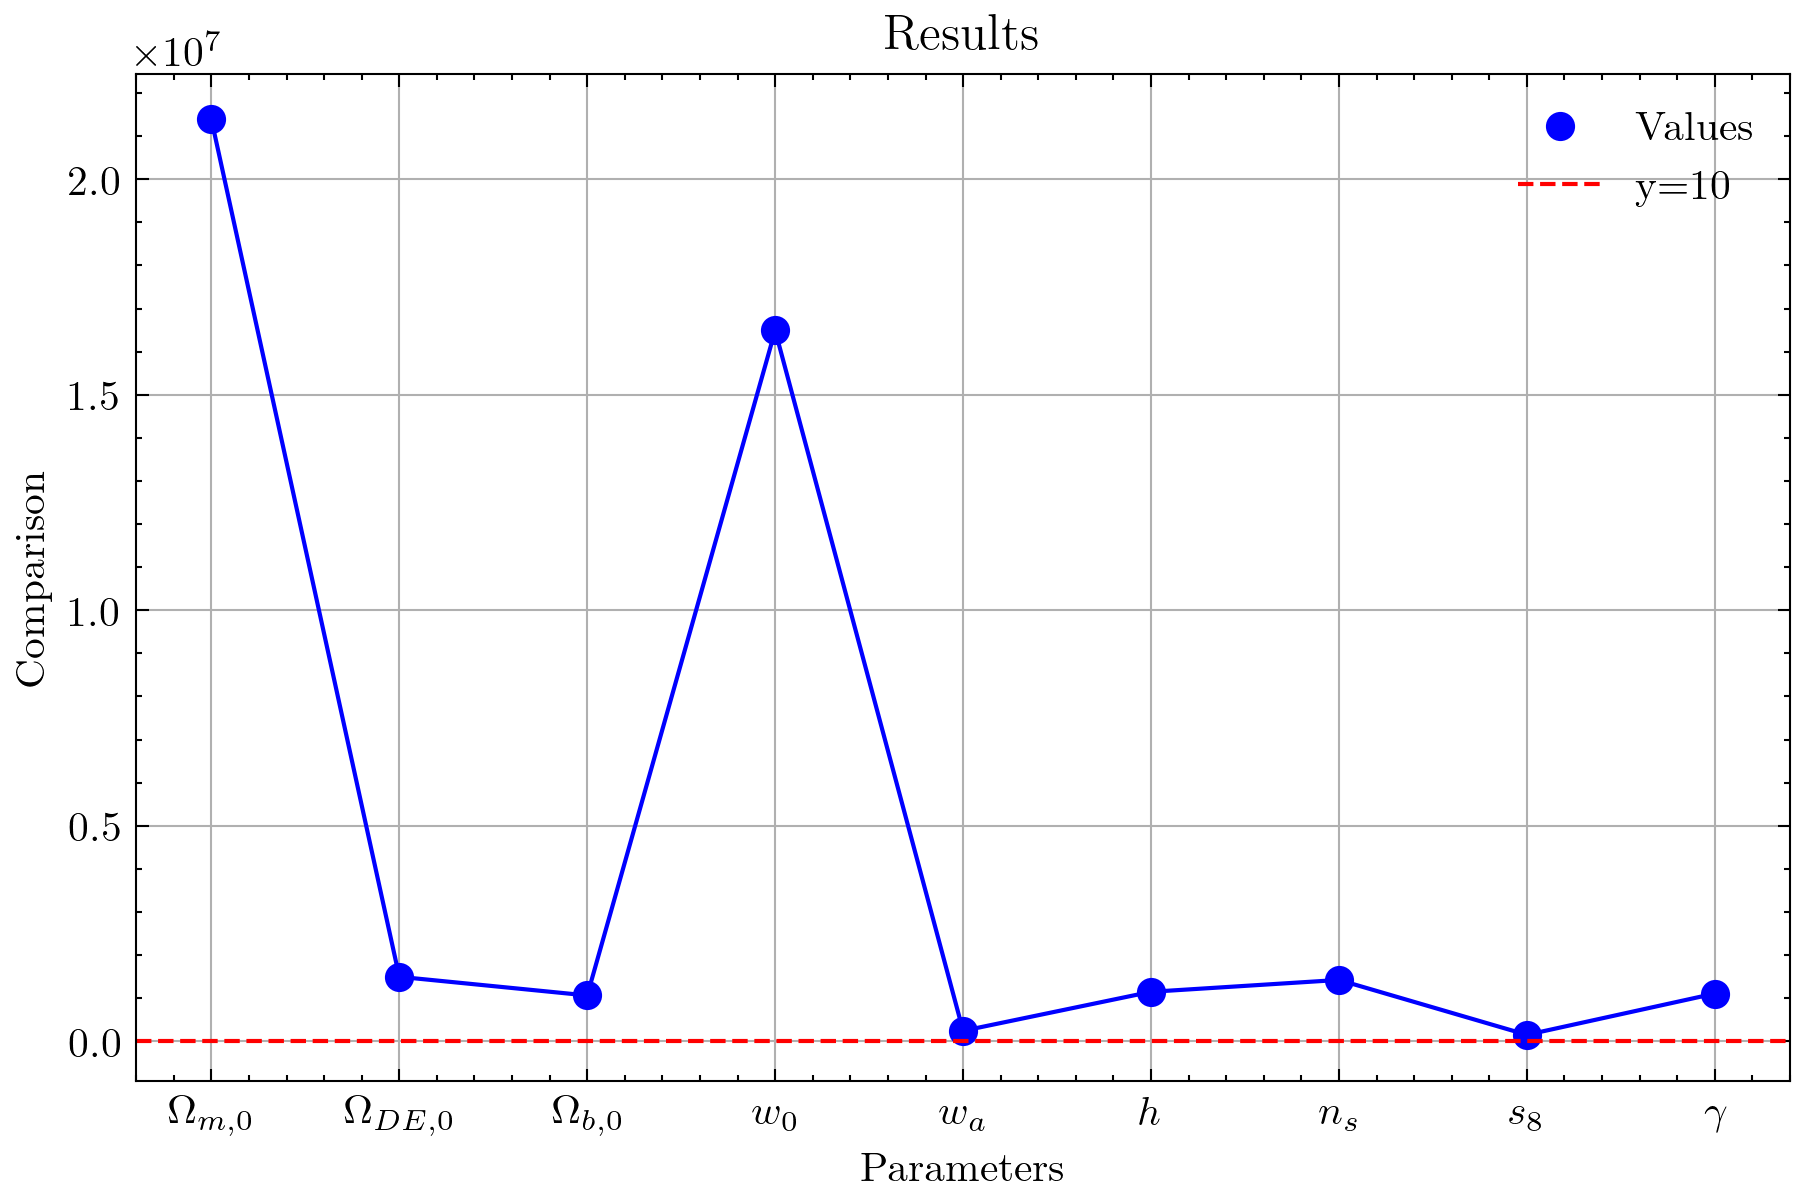

In [548]:
import matplotlib.pyplot as plt

# Asegurarse de que LaTeX esté habilitado en Matplotlib
plt.rcParams['text.usetex'] = True
fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True, figsize=(6, 4), constrained_layout=True, dpi=300)

# Etiquetas con LaTeX
labels = [r'$\Omega_{m,0}$', r'$\Omega_{DE,0}$', r'$\Omega_{b,0}$', r'$w_0$', r'$w_a$', r'$h$', r'$n_s$', r'$s_8$', r'$\gamma$']

# Graficar los datos
ax.plot(labels, validated, 'o', color='blue', label='Values')

# Graficar la línea que une los puntos
ax.plot(labels, validated, '-', color='blue')

ax.axhline(y=10, color='r', linestyle='--', label='y=10')
ax.legend(loc='upper right')
ax.set_xlabel('Parameters')
ax.set_ylabel('Comparison')
ax.set_title('Results')
ax.grid(True)

plt.show()

### Graficando los intervalos de confianza

In [549]:
def plot_ellipse(a, b, phi, center_alpha=0, center_beta=0):
    t = np.linspace(0, 2 * np.pi, 100)    
    x = a * np.cos(t)
    y = b * np.sin(t)
    #rotación
    x_rot = x * np.cos(phi) - y * np.sin(phi)
    y_rot = x * np.sin(phi) + y * np.cos(phi)
    
    x_rot += center_alpha
    y_rot += center_beta
    # Graficar la elipse
    fig, ax = plt.subplots()
    ax.plot(x_rot, y_rot, label=f'Elipse a={round(a, 2)}, b={round(b, 2)}, θ={np.degrees(phi):.1f}°')
    
    plt.legend()
    plt.title('Confidence regions')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    plt.grid(True)
    plt.show()


In [550]:
#alpha = h
#beta = wm
A = 2.3
alpha = 2
beta = 3
# A = 6.18 2 sigma
#A = 11.8  3 sigma
a = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) + np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
b = A * np.sqrt((0.5 *(C_final[alpha,alpha] + C_final[beta,beta])) - np.sqrt((0.25*((C_final[alpha,alpha] - C_final[beta,beta])**2)) + (C_final[alpha, beta]**2)))
phi = np.radians(0.5 * np.arctan((2* C_final[alpha, beta]) / (C_final[alpha,alpha] - C_final[beta,beta])))

print('phi=', phi)
print('a=', a)
print('b=', b)

plot_ellipse(a, b, phi, center_alpha= h, center_beta= wm)


phi= -3.762201102447841e-05
a= 151725.3587763073
b= 43.49417555401164


RuntimeError: latex was not able to process the following string:
b'Elipse a=151725.36, b=43.49, \\u03b8=-0.0\\xb0'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpr6ei902s b2aa69e470e2e08b4ba0617485faf8b9.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.4) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(b2aa69e470e2e08b4ba0617485faf8b9.tex
LaTeX2e <2024-11-01>
L3 programming layer <2024-10-09>
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amsfonts.sty))

(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/firstaid\underscore-ltx
.sty) (C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty
)
(C:\Users\antoc\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file b2aa69e470e2e08b4ba0617485faf8b9.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character θ (U+03B8)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily Elipse a=151725.36, b=43.49, θ
                                               =-0.0°}%
No pages of output.
Transcript written on C:\Users\antoc\.matplotlib\tex.cache\b2\aa\tmpr6ei902s\b2
aa69e470e2e08b4ba0617485faf8b9.log.




<Figure size 350x262.5 with 1 Axes>